# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [10]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2, use_multiprocessing = False)
print(dynamics.dt)


0.04


In [11]:
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(4)
Q[0, 0] = 10.0
Q[1, 1] = 10.0


# Terminal state cost.
Q_terminal = 100 * Q

# Instantaneous control cost.
R = 10 * np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [12]:
N = 100
x0 = np.array([0.0, np.pi - 1, 0.0, 0.0])
us_init = np.array([[-4.76751939e-01],
 [ 3.34490970e-01],
 [-3.99608551e-01],
 [ 8.41882163e-01],
 [-8.93302461e-01],
 [-3.57273055e-01],
 [-3.32158856e-01],
 [-4.82030121e-01],
 [-6.84388675e-01],
 [-4.26475287e-01],
 [-4.90913171e-01],
 [ 1.14754770e-01],
 [ 3.90275383e-01],
 [-4.36421243e-01],
 [ 5.57806778e-01],
 [ 7.83813923e-01],
 [-3.27778717e-01],
 [ 8.00582346e-01],
 [-8.49640982e-01],
 [-5.69222128e-01],
 [ 2.58447724e-01],
 [ 6.02857039e-01],
 [-6.11855326e-01],
 [ 7.00853348e-01],
 [-9.31090157e-01],
 [ 4.97665652e-01],
 [ 2.45721323e-01],
 [-1.92025996e-01],
 [ 2.72219728e-02],
 [ 7.95701514e-01],
 [-8.92320606e-01],
 [ 3.22802941e-02],
 [ 2.69562194e-01],
 [-1.46125346e-01],
 [-3.15934186e-02],
 [ 6.61809200e-01],
 [ 4.76622656e-01],
 [-9.78007260e-01],
 [ 5.73481914e-01],
 [-1.28208542e-02],
 [ 1.48147746e-01],
 [ 1.39421731e-04],
 [ 1.08812740e-01],
 [ 6.16007441e-01],
 [ 2.66982969e-01],
 [-2.09250070e-02],
 [ 6.04343953e-02],
 [ 4.14836049e-01],
 [-7.01346473e-01],
 [ 2.94563133e-01],
 [-3.07180590e-01],
 [ 6.53429823e-01],
 [ 3.87696411e-01],
 [-1.60361255e-01],
 [-7.91982930e-01],
 [ 3.04331662e-01],
 [-3.33057338e-01],
 [-1.45487867e-01],
 [-4.48293362e-01],
 [-4.56753222e-01],
 [-5.63113978e-02],
 [ 9.17106858e-01],
 [-7.79117478e-01],
 [-7.74944928e-01],
 [ 1.26081663e-01],
 [ 8.11397037e-02],
 [-6.58667412e-01],
 [ 9.01877119e-01],
 [-7.59017615e-01],
 [-6.54909707e-01],
 [-7.19152458e-01],
 [-8.23250291e-01],
 [-1.96576912e-01],
 [ 3.31076346e-01],
 [-9.59322994e-01],
 [ 6.61615691e-01],
 [-4.48940253e-01],
 [-4.10547311e-01],
 [-8.26340358e-01],
 [ 7.48939731e-01],
 [-8.83894866e-01],
 [ 4.12684469e-01],
 [-4.61578622e-01],
 [-8.29689676e-01],
 [-9.02561735e-01],
 [-2.44970624e-01],
 [ 2.86652487e-01],
 [-8.59512109e-01],
 [-5.89043961e-01],
 [ 6.21286175e-01],
 [-4.02464523e-01],
 [-7.80221770e-01],
 [-7.58513349e-01],
 [ 5.35469863e-01],
 [ 7.43535637e-01],
 [ 9.40814704e-01],
 [-9.31071558e-01],
 [-4.20465454e-01],
 [-1.28056017e-01],
 [-2.09487816e-01]])
#us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost1, N)

In [13]:
t0 = time.time()
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print('\n\n\n\n\n')
print('time', time.time() - t0)

iteration 0 accepted 28533.593878784424 [-1.68990103  2.0224095   0.85810737 -7.06819596]
iteration 1 accepted 28337.895526134474 [-1.53736295  3.03661713  2.43842915 -3.97308855]
iteration 2 accepted 24748.15986695675 [-0.55951526  1.83832383  1.25906257 -7.39646369]
iteration 3 accepted 20097.152068031173 [ 0.27201966  2.48730021  0.33880215 -1.33648801]
iteration 4 accepted 19157.477761366714 [ 0.51861723  1.50175937 -0.45247713 -6.0812405 ]
iteration 5 accepted 18566.534728859948 [ 0.22280006  2.34050764 -1.87420607 -3.35938341]
iteration 6 accepted 16030.944366389711 [ 0.45262709  2.18235034 -2.17296226  0.83401558]
iteration 7 accepted 14085.054578797759 [ 0.2722499   1.54859097 -2.1675487  -2.44767927]
iteration 8 accepted 13660.231206139353 [ 0.19203194  1.3911044  -2.00925634 -2.06984311]
iteration 9 accepted 13211.990948158833 [ 0.20823074  1.50489499 -1.79517105 -0.95647055]
iteration 10 accepted 13138.721506524042 [ 0.24334511  1.39243256 -1.68739599 -0.89825686]
iteration 

iteration 97 accepted 7383.1905745853055 [-0.02257966 -0.03289334  0.17222888  0.08459385]
iteration 98 accepted 7359.103749255047 [ 0.00406093 -0.01724689  0.09109673  0.04825406]
iteration 99 accepted 7319.443715027803 [ 0.00175227 -0.01784714  0.09461989  0.04939834]
iteration 100 accepted 7289.8043774801445 [-0.01069821 -0.02150498  0.11344372  0.05644812]
iteration 101 accepted 7234.545715995367 [-0.00323453 -0.01813092  0.09472926  0.04835174]
iteration 102 accepted 7193.079913445371 [ 0.00531963 -0.01116423  0.05815176  0.03128376]
iteration 103 accepted 7159.79147839216 [-0.00919116 -0.02018027  0.10416173  0.05225262]
iteration 104 accepted 7131.8340888440935 [-0.0109665  -0.02042976  0.10504801  0.05223308]
iteration 105 accepted 7109.49182206297 [-0.00480105 -0.01758867  0.08919749  0.04537093]
iteration 106 accepted 7099.518669410311 [-0.0179566  -0.02489764  0.12720407  0.06240916]
iteration 107 accepted 7052.895981273126 [-0.0103579  -0.02044068  0.10334082  0.05167303]
i

iteration 194 accepted 4490.56209693683 [ 0.00242242  0.00182091 -0.01057588 -0.00485318]
iteration 195 accepted 4441.810795332796 [ 0.00292409  0.00313474 -0.0162023  -0.00776256]
iteration 196 accepted 4419.678024567645 [ 0.00097219 -0.00037956 -0.00020376  0.00029775]
iteration 197 accepted 4419.472503665906 [ 0.0023392   0.00202962 -0.0112949  -0.00527205]
iteration 198 accepted 4360.967588484432 [ 0.0023983   0.00211596 -0.01170489 -0.0054755 ]
iteration 199 accepted 4348.1456318218825 [ 0.00157906  0.00088413 -0.00583976 -0.00256559]
iteration 200 accepted 4340.380238683657 [ 0.00242263  0.00248523 -0.01312073 -0.00624632]
iteration 201 accepted 4298.72502642423 [ 0.00220736  0.00214014 -0.01148734 -0.00543161]
iteration 202 accepted 4278.653737604867 [ 0.00209676  0.00200375 -0.01080404 -0.00509856]
iteration 203 accepted 4248.564030810168 [ 0.00197358  0.00206197 -0.01081141 -0.00515215]
iteration 204 accepted 4227.825321716889 [ 0.00179527  0.00158519 -0.00878984 -0.00410487]


iteration 281 accepted 2413.0097197728805 [-1.23957505e-05  1.02677941e-05 -6.34993845e-05 -7.02656769e-06]
iteration 282 accepted 2412.633801347147 [-1.39155778e-05  9.51408813e-06 -5.78503088e-05 -4.56273207e-06]
iteration 283 accepted 2412.400252658564 [-1.47135338e-05  8.97680140e-06 -5.43740982e-05 -2.98627751e-06]
iteration 284 accepted 2412.2710678301423 [-1.52247441e-05  8.60568249e-06 -5.20373911e-05 -1.91710206e-06]
iteration 285 accepted 2412.1873929279086 [-1.54703586e-05  8.34067650e-06 -5.06012192e-05 -1.22975376e-06]
iteration 286 accepted 2412.137675520279 [-1.56574315e-05  8.16727373e-06 -4.96054008e-05 -7.61138307e-07]
iteration 287 accepted 2412.1047842341477 [-1.57313317e-05  8.04263604e-06 -4.90086189e-05 -4.63397368e-07]
iteration 288 accepted 2412.0843702914913 [-1.58068348e-05  7.96411880e-06 -4.85740329e-05 -2.56390517e-07]
iteration 289 accepted 2412.0707738012034 [-1.58261573e-05  7.90732345e-06 -4.83295632e-05 -1.29666643e-07]
iteration 290 accepted 2412.062

In [64]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

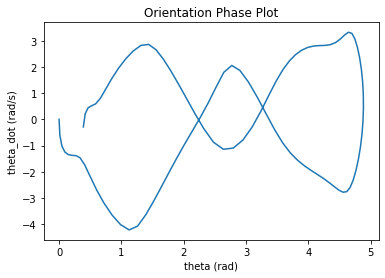

In [19]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

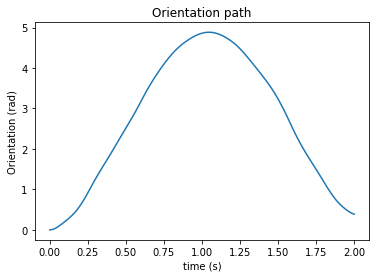

In [20]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

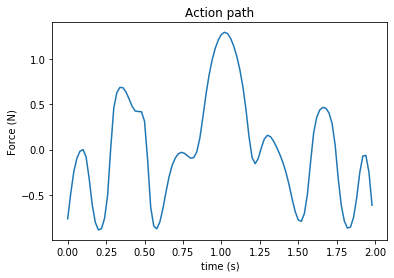

In [21]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

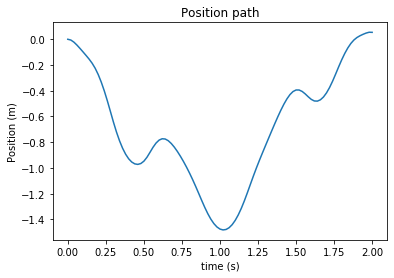

In [22]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

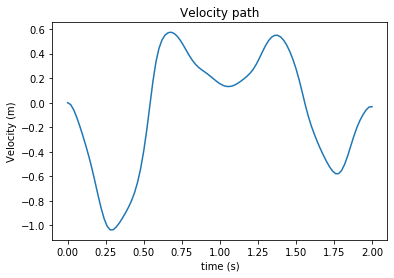

In [23]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

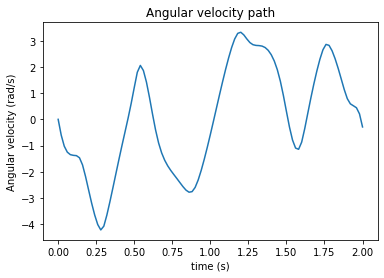

In [24]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

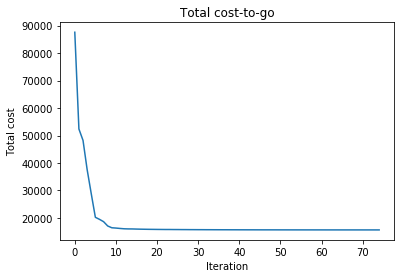

In [25]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [26]:
viewer = MjViewer(dynamics.sim)
dynamics.set_state(x0)
print(dynamics.get_state())
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    viewer.render()

Creating window glfw
[0. 0. 0. 0. 0. 0.]
0 [-0.76335289]
[-0.00601022  0.01244272 -0.01592262 -0.60117275  1.24536422 -1.5941919 ] [-0.00601022  0.01244272 -0.01592262 -0.60117275  1.24536422 -1.5941919 ]

1 [-0.4841633]
[-0.02225183  0.04618335 -0.05919637 -1.02334554  2.13221256 -2.73980399] [-0.02225183  0.04618335 -0.05919637 -1.02334554  2.13221256 -2.73980399]

2 [-0.24395837]
[-0.0449949   0.09383804 -0.12063258 -1.25122426  2.63701715 -3.40985029] [-0.0449949   0.09383804 -0.12063258 -1.25122426  2.63701715 -3.40985029]

3 [-0.09534612]
[-0.07097268  0.14909915 -0.1924288  -1.34679603  2.89323875 -3.77607813] [-0.07097268  0.14909915 -0.1924288  -1.34679603  2.89323875 -3.77607813]

4 [-0.01839246]
[-0.09817236  0.20834427 -0.27025563 -1.37342669  3.03576354 -4.01343172] [-0.09817236  0.20834427 -0.27025563 -1.37342669  3.03576354 -4.01343172]

5 [-0.00028044]
[-0.1257528   0.27037959 -0.35283354 -1.38470629  3.17136379 -4.24851423] [-0.1257528   0.27037959 -0.35283354 -1.38470

53 [1.22583394]
[-1.44112424  4.8706744   0.13540957  1.42573361 -0.77320539  0.35872188] [-1.44112424  4.8706744   0.13540957  1.42573361 -0.77320539  0.35872188]

54 [1.14192526]
[-1.40785533  4.85089648  0.14522874  1.90017721 -1.19931532  0.61183947] [-1.40785533  4.85089648  0.14522874  1.90017721 -1.19931532  0.61183947]

55 [1.02844321]
[-1.36540243  4.82295408  0.15949517  2.34385953 -1.5879291   0.79953632] [-1.36540243  4.82295408  0.15949517  2.34385953 -1.5879291   0.79953632]

56 [0.88144116]
[-1.31453436  4.78765695  0.17684988  2.74154294 -1.93383473  0.91846048] [-1.31453436  4.78765695  0.17684988  2.74154294 -1.93383473  0.91846048]

57 [0.69111808]
[-1.2564209   4.74581803  0.19614513  3.06833614 -2.24214236  0.99340643] [-1.2564209   4.74581803  0.19614513  3.06833614 -2.24214236  0.99340643]

58 [0.44108542]
[-1.19291919  4.69796465  0.21721519  3.28030138 -2.53665452  1.09811504] [-1.19291919  4.69796465  0.21721519  3.28030138 -2.53665452  1.09811504]

59 [0.1389

In [19]:
print(dynamics.get_state())
print(xs[-1])

[-1.58829179e-05  7.80945804e-06 -4.78586791e-05  1.05357655e-07]
[-1.58829179e-05  7.80945804e-06 -4.78586791e-05  1.05357655e-07]


In [20]:
#FOR TESTING PURPOSES

In [21]:
dynamics1 = MujocoDynamics(xml_path, frame_skip = 2, bounds = np.array([[-1, 1]]), x_eps = np.sqrt(np.finfo(float).eps), u_eps = np.sqrt(np.finfo(float).eps))
dynamics2 = CartpoleDynamics(0.04)

In [22]:
state = np.array([0.0,0.0,0.0,0.0])
action = np.array([-0.37])

In [23]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_x = np.vstack([
            approx_fprime(state, lambda x: helper(x, action)[m], 1.5e-8)
            for m in range(dynamics1.state_size)
        ])
print(f_x)
print(count)

[[ 1.00000000e+00 -1.44920037e-03  3.99265566e-02  1.45175972e-04]
 [ 0.00000000e+00  1.01416466e+00  1.72073698e-04  3.85840789e-02]
 [ 0.00000000e+00 -9.21244655e-02  9.96339017e-01  6.25374752e-03]
 [ 0.00000000e+00  9.01528245e-01  8.51160994e-03  9.39039420e-01]]
20


In [24]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_x = np.empty((dynamics1.state_size, dynamics1.state_size))

dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
for i in range(dynamics1.sim.model.nq):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qpos[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, i] = deriv

for i in range(dynamics1.sim.model.nv):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qvel[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, dynamics1.sim.model.nq + i] = deriv
print(f_x)
print(count)

[[ 1.00000000e+00 -1.44920035e-03  3.99265566e-02  1.45175960e-04]
 [ 0.00000000e+00  1.01416466e+00  1.72073720e-04  3.85840788e-02]
 [ 0.00000000e+00 -9.21244659e-02  9.96339018e-01  6.25374727e-03]
 [ 0.00000000e+00  9.01528247e-01  8.51161033e-03  9.39039417e-01]]
5


In [25]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_u = np.vstack([
            approx_fprime(action, lambda u: helper(state, u)[m], dynamics1.u_eps)
            for m in range(dynamics1.state_size)
        ])

print(f_u)
print(count)

[[ 0.00642402]
 [-0.01505111]
 [ 0.32022242]
 [-0.74450151]]
8


In [26]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_u = np.empty((dynamics1.state_size, dynamics1.action_size))


for i in range(dynamics1.action_size):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    action[i] += dynamics1.u_eps
    dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.u_eps
    f_u[:, i] = deriv

    action[i] -= dynamics1.u_eps
print(f_u)
print(count)

[[ 0.00642402]
 [-0.01505111]
 [ 0.32022242]
 [-0.74450151]]
2


In [10]:
from mujoco_py import MjSimPool

ImportError: cannot import name 'MjSimPool' from 'mujoco_py' (/Users/jimwang/mujoco-py/mujoco_py/__init__.py)

In [13]:
import multiprocessing as mp
print(mp.cpu_count())

16


In [14]:
7 // 2

3